In [33]:
# Necessary imports
%load_ext autoreload
%autoreload 2\

import networkx as nx
import numpy as np
import pandas as pd

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [34]:
from TCGAMultiOmics.multiomics import MultiOmicsData

folder_path = "/home/jonny_admin/PycharmProjects/Bioinformatics_ExternalData/tcga-assembler/LUAD"
external_data_path = "/home/jonny_admin/PycharmProjects/Bioinformatics_ExternalData/"
luad_data = MultiOmicsData(cancer_type="LUAD", tcga_data_path=folder_path, external_data_path=external_data_path,
                           modalities=[\
                                       "GE",
                                       "MIR",
                                       "LNC",
                                       # "CNV",
                                       # "SNP",
#                                        "PRO"
                                       ])



/opt/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3781: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)
/opt/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2963: DtypeWarning: Columns (1,3) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


PATIENTS (522, 5)
DRUGS (461, 4)
GE (576, 20472)
MIR (494, 1870)
LNC (546, 12727)
SAMPLES (599, 6)


# Heterogeneous Network

In [3]:
from moge.network.heterogeneous_network import HeterogeneousNetwork
network = HeterogeneousNetwork(modalities=["MIR", "LNC", "GE"], multi_omics_data=luad_data)

MIR  nodes: 1870
LNC  nodes: 12727
GE  nodes: 20472
Total nodes: 35069


In [4]:
# Adds miRNA-target interaction network
network.add_edges_from_edgelist(edgelist=luad_data.MIR.get_miRNA_target_interaction_edgelist(), 
                                modalities=["MIR", "GE"])

Adding edgelist with 247 total unique MIR genes (source), but only matching 247 nodes
Adding edgelist with 12014 total unique GE genes (target), but only matching 12014 nodes


In [5]:
# Adds Gene Regulatory Network edges
network.add_edges_from_edgelist(edgelist=luad_data.GE.get_RegNet_GRN_edgelist(),
                               modalities=["GE", "GE"])

Adding edgelist with 2072 total unique GE genes (source), but only matching 1426 nodes
Adding edgelist with 23158 total unique GE genes (target), but only matching 17694 nodes


In [9]:
# Adds miRNA-lncRNA interaction network
network.add_edges_from_edgelist(edgelist=luad_data.LNC.get_starBase_lncRNA_miRNA_interactions_edgelist(),
                               modalities=["MIR", "LNC"])

Adding edgelist with 275 total unique MIR genes (source), but only matching 238 nodes
Adding edgelist with 1127 total unique LNC genes (target), but only matching 582 nodes


In [ ]:
print(len(network.G.nodes()))
print(len(network.G.edges()))
# print(luad_data.LNC.get_genes_list())

In [ ]:
mir_ge_corr = network.compute_multiomics_correlations(modalities=["MIR", "GE"])

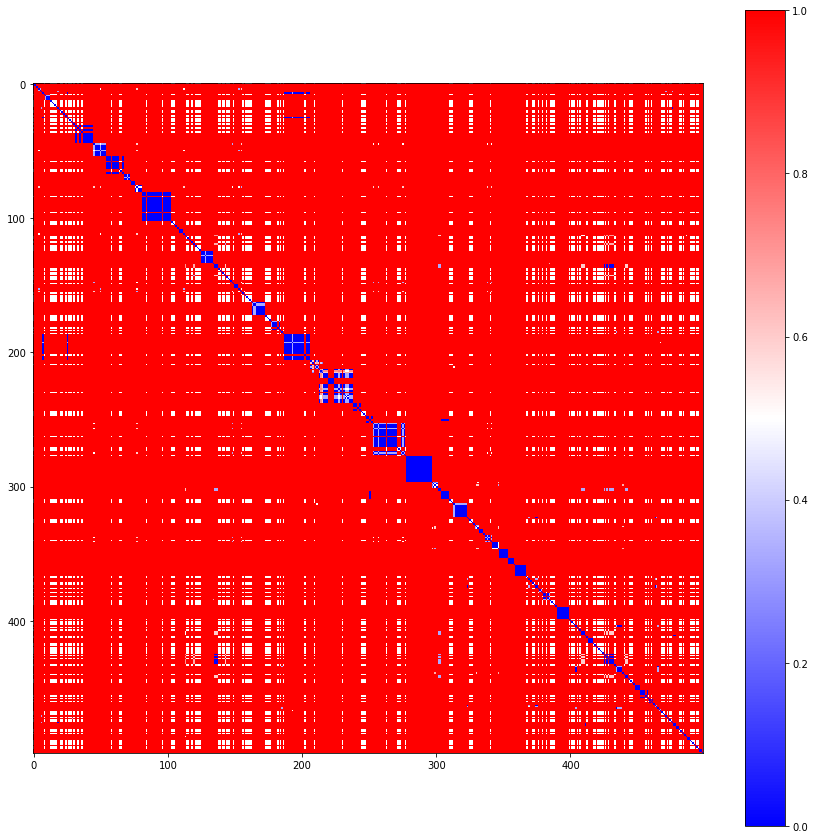

In [62]:
# Scatter plot of original graph adjacency matrix
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 15))
plt.imshow(anno_dist, interpolation='nearest', cmap=plt.cm.bwr)
plt.colorbar()
plt.show()

# Laplacian Matrix

In [ ]:
import community
G = nx.read_edgelist('moge/data/karate.edgelist', create_using=nx.Graph())


In [ ]:
A = nx.adjacency_matrix(G)
A.setdiag(A.diagonal()*2)
A = A.todense()

In [ ]:
# -np.sqrt(np.sum(A, axis=1).A1)
# D = np.diag(-np.sqrt(np.sum(A, axis=1).A1))
D = np.diag(np.sum(A, axis=1).A1)

In [ ]:
L = D-A

In [ ]:
print(nx.incidence_matrix(G, oriented=True).shape)
pd.DataFrame(nx.incidence_matrix(G, oriented=True)*nx.incidence_matrix(G, oriented=True).todense().T)

In [ ]:
pd.DataFrame(nx.laplacian_matrix(G).todense())

In [ ]:
from scipy.linalg import decomp_svd
U, s, Vh = decomp_svd.svd(nx.laplacian_matrix(G).todense())

In [ ]:
U[0,:].shape

In [ ]:
partition = community.best_partition(G)
size = float(len(set(partition.values())))
pos = nx.spring_layout(G)
count = 0.
for com in set(partition.values()) :
    count = count + 1.
    list_nodes = [nodes for nodes in partition.keys()
                                if partition[nodes] == com]
    nx.draw_networkx_nodes(G, pos, list_nodes, node_size = 20,
                                node_color = str(count / size))


nx.draw_networkx_edges(G, pos, alpha=0.5)
plt.show()

In [ ]:
# Scatter plot of original graph adjacency matrix
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 15))
plt.imshow(U, interpolation='nearest', cmap=plt.cm.bwr)
plt.colorbar()
plt.show()

# Import Graph Embedding Methods

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx

from gem.utils import graph_util, plot_util
from gem.evaluation import visualize_embedding as viz
from gem.evaluation import evaluate_graph_reconstruction as gr
from gem.evaluation.metrics import getPrecisionReport
from gem.evaluation.evaluate_link_prediction import evaluateStaticLinkPrediction

from time import time

from gem.embedding.gf       import GraphFactorization
from gem.embedding.hope     import HOPE
from gem.embedding.lap      import LaplacianEigenmaps
from gem.embedding.lle      import LocallyLinearEmbedding
from gem.embedding.node2vec import node2vec
from gem.embedding.sdne     import SDNE
from moge.embedding.dual_graph_embedding import DualGraphEmbedding


# File that contains the edges. Format: source target
# Optionally, you can add weights as third column: source target weight

# Specify whether the edges are directed
isDirected = True

# Load graph
# G = graph_util.loadGraphFromEdgeListTxt(edge_f, directed=isDirected)
# G = G.to_directed()

# G = nx.read_edgelist('../nuclei-segmentation/notebooks/gem/data/ppi.edgelist', create_using=nx.DiGraph())
G = nx.read_edgelist('moge/data/karate.edgelist', create_using=nx.DiGraph())

# G = network.G

# G = nx.convert_node_labels_to_integers(G)

In [ ]:
models = []
# You can comment out the methods you don't want to run
# models.append(HOPE(d=100, beta=0.1))
models.append(GraphFactorization(d=200, max_iter=100, eta=1*10**-4, regu=1.0))
# models.append(LaplacianEigenmaps(d=2))
# models.append(LocallyLinearEmbedding(d=100))
# models.append(node2vec(d=100, max_iter=1, walk_len=80, num_walks=10, con_size=10, ret_p=1, inout_p=1))
models.append(SDNE(d=200, beta=5, alpha=1e-5, nu1=1e-6, nu2=1e-6, 
                   K=3, n_units=[50, 15,], rho=0.3, 
                   n_iter=100, xeta=0.01, n_batch=500))

models.append(DualGraphEmbedding(d=100, reg=1.0, lr=0.05, iterations=100))
                   

In [ ]:
print ('Num nodes: %d, num edges: %d' % (G.number_of_nodes(), G.number_of_edges()))
for embedding in models:
    try:
        print("\n", embedding.get_method_name(), embedding.get_method_summary())
        t1 = time()
        
    #     Learn embedding - accepts a networkx graph or file with edge list
#         embedding.learn_embedding(graph=G, edge_f=None, is_weighted=True, no_python=True)
#         print (embedding._method_name+':\n\tTraining time: %f' % (time() - t1))

#         Y = embedding.get_embedding()

#         # Evaluate on graph reconstruction
#         MAP, prec_curv, err, err_baseline = gr.evaluateStaticGraphReconstruction(G, embedding, Y, None)
#         print ("Graph Reconstruction. MAP:", MAP)

        
        # Evaluate on link prediction
        MAP, prec_curv = evaluateStaticLinkPrediction(G, embedding,
                                     train_ratio=0.8,
                                     is_undirected=False)
        print ("Link Prediction. MAP:", MAP)
        print (embedding._method_name+':\n\tTraining time: %f' % (time() - t1))
        
        # Visualize
#         viz.plot_embedding2D(embedding.get_embedding(), di_graph=G, node_colors=None)
#         plt.show()
    except Exception as e:
        print("could not run", embedding, e)

# Plot Adjacency Matrix

In [ ]:
# Scatter plot of original graph adjacency matrix
graph_adj = nx.laplacian_matrix(G.to_undirected()).todense()
plt.figure(figsize=(9,9))
plt.imshow(graph_adj, interpolation='nearest', cmap=plt.cm.gray)
plt.colorbar()
plt.show()

In [ ]:
# Scatter plot of reconstructed adjacency matrix
plt.figure(figsize=(9,9))
plt.imshow(models[0].get_reconstructed_adj(), interpolation='nearest', cmap=plt.cm.gray)
plt.colorbar()
plt.show()

In [ ]:
from sklearn.manifold import TSNE

model = TSNE(n_components=2)
node_pos = model.fit_transform(models[0].get_embedding())
pos = {}
for i in range(len(G.nodes())):
    pos[i] = node_pos[i, :]
nx.draw_networkx(G, pos, width=0.1, node_size=300, arrows=False,
                             alpha=0.8, font_size=12)